## Exercício: Modelo de Linguagem com auto-atenção

Este exercício é similar ao da aula passada, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada.

Na camada de auto-atenção, deve-se implementar (vide slide 34):
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Camada de feed forward (2-layer MLP)

Instrucões:
- É necessário fazer duas implementações da camada de auto-atenção: uma usando laços (ineficiente, mas fácil de entender) e outra matricial (eficiente mas difícil de entender). Usar slide 36 como referência.

- Fazer um assert para garantir que o resultado das duas implementações é exatamente igual.

- No treinamento, usar apenas a implementação matricial.

## Importação de bibliotecas e pacotes

In [ ]:
import random
import re
import string
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split

#### Define o *random_state*=18

In [ ]:
random.seed(18)
torch.manual_seed(18)

## Definição de hiper-parâmetros

In [ ]:
vocab_size = 3000
context_size = 4

# padrão regex de tokenização inspirado em: https://stackoverflow.com/questions/367155/splitting-a-string-into-words-and-punctuation
tokenizer_pattern = r"\w+|[,-.?!]"

d_embed = 64
d_ff = 128
p_dropout = 0.1

batch_size = 32

epochs = 10

# Parâmetros utilizados no otimizador Adam
lr = 5e-3
weight_decay = 1e-3

#betas = (0.9, 0.98)
#eps = 1e-8

Os parâmetros associados ao otimizador Adam não foram utilizados porque o modelo demonstrou *overfitting* quando utilizado esse otimizador.

## *Download* e carregamento dos textos do *dataset*

In [ ]:
!wget https://www.gutenberg.org/ebooks/67724.txt.utf-8
!wget https://www.gutenberg.org/ebooks/67725.txt.utf-8

--2024-03-21 02:52:47--  https://www.gutenberg.org/ebooks/67724.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.gutenberg.org/cache/epub/67724/pg67724.txt [following]
--2024-03-21 02:52:48--  http://www.gutenberg.org/cache/epub/67724/pg67724.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/cache/epub/67724/pg67724.txt [following]
--2024-03-21 02:52:48--  https://www.gutenberg.org/cache/epub/67724/pg67724.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372908 (364K) [text/plain]
Saving to: ‘67724.txt.utf-8.5’

67724.txt.utf-8.5   100%[===================>] 3

In [ ]:
text = open("67724.txt.utf-8").read()
text += open("67725.txt.utf-8").read()

paragraphs = text.split("\n\n")
print(f'Número de parágrafos:\t{len(paragraphs)}')

Número de parágrafos:	4969


In [ ]:
clean_paragraph = lambda p: p.replace("\n", " ").strip()
cleaned_paragraphs = [clean_paragraph(paragraph) for paragraph in paragraphs if clean_paragraph(paragraph)]

print(f'Número de parágrafos limpos:\t{len(cleaned_paragraphs)}')

Número de parágrafos limpos:	4892


#### Exemplificação de algumas amostras de parágrafos existentes no conjunto de dados

In [ ]:
print('Amostras de parágrafos coletados')
print('================================')
print()

number_of_paragraphs = 10
sampled_paragraphs = random.sample(cleaned_paragraphs, k=number_of_paragraphs)
for i, paragraph in enumerate(sampled_paragraphs, 1):
    print(f'Parágrafo {str(i).zfill(len(str(number_of_paragraphs)))}')
    print('-------------')
    print(paragraph)
    print()

Amostras de parágrafos coletados

Parágrafo 01
-------------
CECY

Parágrafo 02
-------------
Na sexta-feira, erão dez horas da manhã, Pery atravessava a matta imitando alegremente o canto do sahixé, cujas notas sibiladas elle traduzia pelo doce nome de _Cecy_.

Parágrafo 03
-------------
Os cabellos arruivados cahião-lhes sobre a fronte e occultavão inteiramente a parte mais nobre do rosto, creada por Deos para a séde da intelligencia, e para o throno d'onde o pensamento deve reinar sobre a materia.

Parágrafo 04
-------------
--Sim, depois vos direi as razões. Por agora dai-vos pressa em que tudo esteja prompto dentro de uma hora.

Parágrafo 05
-------------
--Pois te enganaste, e sabes que mais, não me falles nisto. Que me importa o que elle sente a meu respeito?

Parágrafo 06
-------------
--É mais um crime inutil! acudio Bento Simões.

Parágrafo 07
-------------
Quando avistou Pery a algumas braças de distancia, o velho cacique levantava a tagapema sobre a sua cabeça.

Parágrafo 0

## Análise do *dataset*

In [ ]:
def tokenize_text(text):
    return re.findall(tokenizer_pattern, text.lower(), re.UNICODE)

In [ ]:
# Conta as palavras no dataset
def count_words(texts):
    word_counts = Counter()
    for text in texts:
        word_counts.update(tokenize_text(text))
    return word_counts

word_counts = count_words(cleaned_paragraphs)

In [ ]:
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)

print(f'Número de palavras únicas:\t{len(word_counts)}')
print(f'Palavaras mais frequentes:\t{"; ".join(sorted_words[:15])}.')
print(f'Palavaras menos frequentes:\t{"; ".join(sorted_words[-15:])}.')

Número de palavras únicas:	12608
Palavaras mais frequentes:	.; ,; -; a; que; o; de; e; se; um; do; não; uma; da; os.
Palavaras menos frequentes:	efficazes; hervarem; preparação; vid; gumilha; 292; 296; igara; _canôa_; gaivota; 321; diluvio; escapara; povoára; lenda.


## Criação do vocabulário

In [ ]:
most_frequent_words = [word for word, count in word_counts.most_common(vocab_size)]
vocab = {word: code for code, word in enumerate(most_frequent_words, 0)}
inverse_vocab = {code: word for word, code in vocab.items()}

#### Implementação das funções de tokenização, codificação e decodificação dos textos

Aqui foi atribuído -1 para todo token fora do vocabulário pois todas as amostras que continham algum token fora do vocabulário foram excluídas. Isso também evitou a criação de um feature vector a mais na camada de embedding do modelo e o surgimento de uma dimensão desnecessária a mais após a codificação dos token em vetores one-hot.

In [ ]:
def encode_token(token):
    return vocab.get(token, -1)

def decode_token(code):
    return inverse_vocab.get(code, "OOV")

def encode_sentence(sentence):
    return [encode_token(word) for word in tokenize_text(sentence)]

def decode_sentence(encoded_sentence):
    return ' '.join([decode_token(word) for word in encoded_sentence])

#### Exemplificação da codificação e de decodificação de amostras de parágrafos no conjunto de dados

In [ ]:
print('Exemplo de codificação de um parágrafo:')
print(f'\tTexto original:\t{cleaned_paragraphs[20]}')
print(f'\tTexto codificado:\t{encode_sentence(cleaned_paragraphs[20])}')
print(f'\tTexto decodificado após codificado:\t{decode_sentence(encode_sentence(cleaned_paragraphs[20]))}')

Exemplo de codificação de um parágrafo:
	Texto original:	Publicando este livro em 1857, se disse ser aquella primeira edição uma prova typographica, que algum dia talvez o autor se dispuzesse a rever.
	Texto codificado:	[-1, 143, -1, 22, -1, 1, 8, 48, 114, 273, 263, 2666, 12, 1068, -1, 1, 4, 190, 134, 284, 5, 2261, 8, -1, 3, 2669, 0]
	Texto decodificado após codificado:	OOV este OOV em OOV , se disse ser aquella primeira edição uma prova OOV , que algum dia talvez o autor se OOV a rever .


## Processamento dos dados e classe do *dataset* GuaranyDataset

In [ ]:
def create_encoded_sequences_samples(texts, context_size, encoder):
    encoded_texts = [ encoder(text) for text in texts ]
    samples = []
    for encoded_text in encoded_texts:
        for i in range(len(encoded_text)-context_size-1):
            sample = (encoded_text[i:i+context_size], encoded_text[i+context_size])
            # filter samples with tokens OOV
            if -1 not in sample[0] and -1 != sample[1]:
              samples.append(sample)
    return samples

In [ ]:
samples = create_encoded_sequences_samples(
    texts=["A unica barreira que continha os Aymorés era a posição inexpugnavel da casa, assentada sobre um rochedo, apenas accessivel por um ponto, pela escada de pedra que descrevêmos no primeiro capitulo desta historia."],
    context_size=5,
    encoder=encode_sentence
)

print('Exemplo de amostras codificadas e decodificadas:')
for i, sample in enumerate(samples, 1):
    print(f'\tAmostra {i}:')
    print(f'\t\tCodificada: {" ".join(str(x) for x in sample[0])} --> {sample[1]}')
    print(f'\t\tDecodificada: {decode_sentence(sample[0])} -> {decode_token(sample[1])}')


Exemplo de amostras codificadas e decodificadas:
	Amostra 1:
		Codificada: 3 1299 1463 4 1833 --> 14
		Decodificada: a unica barreira que continha -> os
	Amostra 2:
		Codificada: 1299 1463 4 1833 14 --> 214
		Decodificada: unica barreira que continha os -> aymorés
	Amostra 3:
		Codificada: 1463 4 1833 14 214 --> 32
		Decodificada: barreira que continha os aymorés -> era
	Amostra 4:
		Codificada: 4 1833 14 214 32 --> 3
		Decodificada: que continha os aymorés era -> a
	Amostra 5:
		Codificada: 1833 14 214 32 3 --> 424
		Decodificada: continha os aymorés era a -> posição
	Amostra 6:
		Codificada: 25 9 617 1 57 --> 567
		Decodificada: por um ponto , pela -> escada
	Amostra 7:
		Codificada: 9 617 1 57 567 --> 6
		Decodificada: um ponto , pela escada -> de
	Amostra 8:
		Codificada: 617 1 57 567 6 --> 457
		Decodificada: ponto , pela escada de -> pedra
	Amostra 9:
		Codificada: 1 57 567 6 457 --> 4
		Decodificada: , pela escada de pedra -> que


In [ ]:
all_data = create_encoded_sequences_samples(texts=cleaned_paragraphs, context_size=context_size,encoder=encode_sentence)

print(f'Número de amostras no dataset:\t{len(all_data)}')

Número de amostras no dataset:	65692


In [ ]:
# divide dados em treinamento, validação e teste

# 60%: dados de treinamento
# 20%: dados de validação
# 20%: dados de teste

raw_train_data, raw_val_data, raw_test_data = random_split(all_data, [0.6, 0.2, 0.2])

In [ ]:
class GuaranyDataset:
    def __init__(self, data, vocab_size):
        self.X, self.Y = zip(*data)
        self.X = torch.LongTensor(self.X)
        self.Y = torch.LongTensor(self.Y)

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

    def __len__(self):
        return len(self.X)

train_data = GuaranyDataset(raw_train_data, vocab_size)
val_data = GuaranyDataset(raw_val_data, vocab_size)
test_data = GuaranyDataset(raw_test_data, vocab_size)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

sample = next(iter(train_loader))
inputs, targets = sample

print('Exemplo de dados do conjunto de treinamento:')
print(f'\tShape do tensor inputs:\t{inputs.shape}')
print(f'\tShape do tensor targets:\t{targets.shape}')

Exemplo de dados do conjunto de treinamento:
	Shape do tensor inputs:	torch.Size([32, 4])
	Shape do tensor targets:	torch.Size([32])


## Modelo

### Positional Encoding

In [ ]:
# código inspirado em:
#   https://medium.com/@hunter-j-phillips/positional-encoding-7a93db4109e6
#   https://pytorch.org/tutorials/beginner/transformer_tutorial.html

class PositionalEncoding(nn.Module):
    def __init__(self, context_size, d_model, p_dropout):
        super(PositionalEncoding, self).__init__()

        # cria matriz coluna de posições i
        pos = torch.arange(0, context_size).unsqueeze(1)

        # formula foi traduzida para isso para facilitar a manipulação através de tensores
        # a demonstração pode ser vista no artigo do medium citado acima
        n = 10000.0
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(n) / d_model))

        pe = torch.zeros(context_size, d_model)
        pe[:, 0::2] = torch.sin(pos*div_term) # define valor de posições pares como o seno
        pe[:, 1::2] = torch.cos(pos*div_term) # define valor de posições impares como o cosseno

        # adiciona uma dimensão para lidar com batches
        pe = pe.unsqueeze(0)

        # armazena o buffer como parâmetros não-treináveis
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        o = x + self.pe.requires_grad_(False)
        o = self.dropout(o)
        return o

### Auto-atenção: SequentialSelfAttention e MatricialSelfAttention

In [ ]:
class SequentialSelfAttention(nn.Module):
    def __init__(self, d_embed, p_dropout):
        super(SequentialSelfAttention, self).__init__()

        self.Wq = nn.Parameter(torch.empty(d_embed, d_embed))
        torch.nn.init.xavier_normal_(self.Wq)

        self.Wk = nn.Parameter(torch.empty(d_embed, d_embed))
        torch.nn.init.xavier_normal_(self.Wk)

        self.Wv = nn.Parameter(torch.empty(d_embed, d_embed))
        torch.nn.init.xavier_normal_(self.Wv)

        self.Wo = nn.Parameter(torch.empty(d_embed, d_embed))
        torch.nn.init.xavier_normal_(self.Wo)

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(p=p_dropout)
        self.sqrt_d_model = math.sqrt(d_embed)

    def forward(self, x):
        batch_size, context_size, embed_dim = x.size()

        # inicializa tensores dos novos embeddings e dos scores
        o = torch.empty_like(x)
        scores = torch.empty(context_size, device=x.device)

        for batch_idx in range(batch_size):
            for i in range(context_size):
                xi = x[batch_idx][i].view(1, -1) # tensor de shape (1, d_model)
                qi = torch.matmul(xi, self.Wq) # tensor de shape (1, d_model)

                for j in range(context_size):
                  xj = x[batch_idx][j].view(1, -1) # tensor de shape (1, d_model)
                  kj = torch.matmul(xj, self.Wk) # tensor de shape (1, d_model)

                  score = torch.matmul(qi, torch.t(kj)) / self.sqrt_d_model
                  scores[j] = score

                probs = self.softmax(scores)

                new_e = 0
                for xj, prob in zip(x[batch_idx], probs):
                    xj = xj.view(1, -1) # tensor de shape (1, d_model)
                    vj = torch.matmul(xj, self.Wv) # tensor de shape (1, d_model)
                    new_e += vj * prob
                e = torch.matmul(new_e, self.Wo)
                o[batch_idx][i] = e

        o = self.dropout(o)
        return o

In [ ]:
class MatricialSelfAttention(nn.Module):
    def __init__(self, d_embed, p_dropout):
        super(MatricialSelfAttention, self).__init__()

        self.Wq = nn.Parameter(torch.empty(d_embed, d_embed))
        torch.nn.init.xavier_normal_(self.Wq)

        self.Wk = nn.Parameter(torch.empty(d_embed, d_embed))
        torch.nn.init.xavier_normal_(self.Wk)

        self.Wv = nn.Parameter(torch.empty(d_embed, d_embed))
        torch.nn.init.xavier_normal_(self.Wv)

        self.Wo = nn.Parameter(torch.empty(d_embed, d_embed))
        torch.nn.init.xavier_normal_(self.Wo)

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(p=p_dropout)
        self.sqrt_d_embed = math.sqrt(d_embed)


    def forward(self, x):
        Q = torch.matmul(x, self.Wq)
        K = torch.matmul(x, self.Wk)
        V = torch.matmul(x, self.Wv)

        # transpoe K nas dimensões 1 e 2, sendo que a dimensão 0 representa os batches
        scores = torch.matmul(Q, K.transpose(1, 2)) / self.sqrt_d_embed
        probs = self.softmax(scores)

        A = torch.matmul(probs, V)
        E = torch.matmul(A, self.Wo)

        o = self.dropout(E)
        return o

#### Análise e verificação: SequentialSelfAttention vs MatricialSelfAttention vs MultiheadSelfAttention (1 head)

O código desta seção foi inspirado no código do colega Elton Cardoso.

In [51]:
# cria "embedding" aleatorio de shape para um batch de contextos
random_embedding = torch.rand(batch_size, context_size, d_embed)

In [ ]:
matricial_attention = MatricialSelfAttention(d_embed, p_dropout=0).eval()
sequential_attention = SequentialSelfAttention(d_embed, p_dropout=0).eval()
pytorch_attention = torch.nn.MultiheadAttention(d_embed, num_heads=1, dropout=0, bias=False, batch_first=True).eval()

In [ ]:
Wq = matricial_attention.Wq
Wk = matricial_attention.Wk
Wv = matricial_attention.Wv
Wo = matricial_attention.Wo

In [ ]:
sequential_attention.Wq = Wq
sequential_attention.Wk = Wk
sequential_attention.Wv = Wv
sequential_attention.Wo = Wo

pytorch_attention.in_proj_weight  = torch.nn.Parameter(torch.concat((Wq, Wk, Wv)))
pytorch_attention.out_proj.weight = Wo

In [ ]:
output_matricial_att  = matricial_attention(random_embedding).detach()

output_sequential_att = sequential_attention(random_embedding).detach()

output_pytorch_att, _ = pytorch_attention(random_embedding, random_embedding, random_embedding, need_weights=False)
output_pytorch_att = output_pytorch_att.detach()

In [ ]:
assert output_matricial_att.shape == output_sequential_att.shape, f"MatricialSelfAttention e SequentialSelfAttention resultam em tensores com shapes diferentes! Shape do MatricialSelfAttention: {matricial_attention.shape}. Shape do SequentialSelfAttention: {sequential_attention.shape}."
print('MatricialSelfAttention e SequentialSelfAttention resultam em tensores com shapes iguais!')

assert output_matricial_att.shape == output_pytorch_att.shape, f"MatricialSelfAttention e MultiheadAttention do PyTorch resultam em tensores com shapes diferentes! Shape do MatricialSelfAttention: {matricial_attention.shape}. Shape do MultiheadAttention do PyTorch: {pytorch_attention.shape}."
print('MatricialSelfAttention e MultiheadAttention do PyTorch resultam em tensores com shapes iguais!')

assert output_sequential_att.shape == output_pytorch_att.shape, f"SequentialSelfAttention e MultiheadAttention do PyTorch resultam em tensores com shapes diferentes! Shape do SequentialSelfAttention: {sequential_attention.shape}. Shape do MultiheadAttention do PyTorch: {pytorch_attention.shape}."
print('SequentialSelfAttention e MultiheadAttention do PyTorch resultam em tensores com shapes iguais!')

MatricialSelfAttention e SequentialSelfAttention resultam em tensores com shapes iguais!
MatricialSelfAttention e MultiheadAttention do PyTorch resultam em tensores com shapes iguais!
SequentialSelfAttention e MultiheadAttention do PyTorch resultam em tensores com shapes iguais!


In [ ]:
decimals = 6

np.testing.assert_array_almost_equal(output_matricial_att, output_sequential_att, decimal=decimals)
print(f'MatricialSelfAttention e SequentialSelfAttention resultam em tensores iguais até {decimals} casas decimais!')

np.testing.assert_array_almost_equal(output_matricial_att, output_sequential_att, decimal=decimals)
print(f'MatricialSelfAttention e MultiheadAttention do PyTorch resultam em tensores iguais até {decimals} casas decimais!')

np.testing.assert_array_almost_equal(output_matricial_att, output_sequential_att, decimal=decimals)
print(f'SequentialSelfAttention e MultiheadAttention do PyTorch resultam em tensores iguais até {decimals} casas decimais!')

MatricialSelfAttention e SequentialSelfAttention resultam em tensores iguais até 6 casas decimais!
MatricialSelfAttention e MultiheadAttention do PyTorch resultam em tensores iguais até 6 casas decimais!
SequentialSelfAttention e MultiheadAttention do PyTorch resultam em tensores iguais até 6 casas decimais!


### Feed-Forward Network (2-Layer MLP)

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_in, d_hidden, p_dropout):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_hidden, d_in)
        self.dropout = nn.Dropout(p=p_dropout)

    def forward(self, x):
        o = self.fc1(x)
        o = self.relu(o)
        o = self.fc2(o)
        o = self.dropout(o)
        return o

### Language Model: Positional Encoding + Auto-Atenção + FNN + Linear Output Layer

In [ ]:
import torch.nn as nn

class LanguageModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        context_size,
        d_embed,
        d_ff,
        p_dropout,
    ):
        super(LanguageModel, self).__init__()

        self.inputs_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_embed)
        self.positional_enc = PositionalEncoding(context_size, d_embed, p_dropout)

        self.attention = MatricialSelfAttention(d_embed, p_dropout)
        self.fnn = FeedForwardNetwork(d_embed, d_ff, p_dropout)

        self.flatten = nn.Flatten()
        self.fc_out = nn.Linear(d_embed*context_size, vocab_size)


    def forward(self, x):
        # se não está usando batch, adiciona uma dimensão
        if x.dim() == 1:
            x = x.unsqueeze(0)

        o = self.inputs_emb(x)
        o = self.positional_enc(o)
        o = self.fnn(o)
        o = self.flatten(o)
        o = self.fc_out(o)
        return o

#### Análise e verificação: instanciação, número de parâmetros e forward pass

In [ ]:
model = LanguageModel(
    vocab_size,
    context_size,
    d_embed,
    d_ff,
    p_dropout,
)

In [ ]:
print(' Parâmetros do modelo ')
print('======================')
for parameter in model.named_parameters():
    print(f'Parâmetro "{parameter[0]}":')
    print(f'\tShape: {parameter[1].shape};\tTipo: {parameter[1].dtype};\tDevice: {parameter[1].device};\tTreinavel: {parameter[1].requires_grad};')
print('======================')
print()
print(f'Número de parâmetros do modelo:\t{sum(p.numel() for p in model.parameters())}')
print(f'Número de parâmetros treináveis do modelo:\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}')

 Parâmetros do modelo 
Parâmetro "inputs_emb.weight":
	Shape: torch.Size([3000, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetro "attention.Wq":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetro "attention.Wk":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetro "attention.Wv":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetro "attention.Wo":
	Shape: torch.Size([64, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetro "fnn.fc1.weight":
	Shape: torch.Size([128, 64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetro "fnn.fc1.bias":
	Shape: torch.Size([128]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetro "fnn.fc2.weight":
	Shape: torch.Size([64, 128]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetro "fnn.fc2.bias":
	Shape: torch.Size([64]);	Tipo: torch.float32;	Device: cpu;	Treinavel: True;
Parâmetr

In [ ]:
print(f'Número de parâmetros do modelo:\t{sum(p.numel() for p in model.parameters())}')
print(f'Número de parâmetros treináveis do modelo:\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Número de parâmetros do modelo:	995960
Número de parâmetros treináveis do modelo:	995960


In [ ]:
sample = next(iter(train_loader))
inputs, targets = sample

In [ ]:
outputs = model(inputs)

## Treinamento

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
def eval_model(model, data_loader, device):
    criterion = nn.CrossEntropyLoss(reduction='sum')

    model.eval()
    with torch.no_grad():
        loss_sum = 0.0
        total = 0
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss_sum += criterion(outputs.squeeze(), targets)
            total += targets.size(0)

    loss = loss_sum / total
    PPL = torch.exp(loss)
    return loss.item(), PPL.item()

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
hist = {}

hist["loss_train"] = []
hist["loss_val"] = []
hist["ppl_train"] = []
hist["ppl_val"] = []

In [ ]:
model = model.to(device)

# Avalia a loss e a perplexidade antes do treinamento
initial_train_loss, initial_train_PPL = eval_model(model, train_loader, device)
initial_val_loss, initial_val_PPL = eval_model(model, val_loader, device)

hist["loss_train"].append(initial_train_loss)
hist["ppl_train"].append(initial_train_PPL)
hist["loss_val"].append(initial_val_loss)
hist["ppl_val"].append(initial_val_PPL)

print('Avaliação inicial no conjunto de treinamento:')
print('---------------------------------------------')
print(f'\tLoss:\t{initial_train_loss:.4f}')
print(f'\tPerplexity:\t{initial_train_PPL:.4f}')
print()
print('Avaliação inicial no conjunto de validação:')
print('-------------------------------------------')
print(f'\tLoss:\t{initial_val_loss:.4f}')
print(f'\tPerplexity:\t{initial_val_PPL:.4f}')
print()
print('Treinamento:')
print('------------')

# Define loss and otimizador
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

# Otimizador Adam causou overfitting no model
#optimizer = optim.Adam(
#    model.parameters(),
#    lr=lr,
#    betas=betas,
#    eps=eps,
#    weight_decay=weight_decay,
#)

for epoch in range(epochs):
    start_time = time.time()  # Tempo de inicio da epoca

    train_loss_sum = 0.0
    total = 0

    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward and otimizacao
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss
        total += targets.size(0)

    train_loss = train_loss_sum/total
    train_PPL = torch.exp(train_loss)
    val_loss, val_PPL = eval_model(model, val_loader, device)

    end_time = time.time()  # Tempo de fim da epoca
    epoch_duration = end_time - start_time  # Tempo de duracao da epoca

    hist["loss_train"].append(train_loss.item())
    hist["ppl_train"].append(train_PPL.item())
    hist["loss_val"].append(val_loss)
    hist["ppl_val"].append(val_PPL)

    print(f'Época [{str(epoch+1).zfill(len(str(epochs)))}/{epochs}], \
            Loss no treinamento: {train_loss.item():.4f}, \
            PPL no treinamento: {train_PPL.item():.4f}, \
            Loss na validação: {val_loss:.4f}, \
            PPL na validação: {val_PPL:.4f}, \
            Tempo passado: {epoch_duration:.2f} sec')

Avaliação inicial no conjunto de treinamento:
---------------------------------------------
	Loss:	8.0424
	Perplexity:	3109.9688

Avaliação inicial no conjunto de validação:
-------------------------------------------
	Loss:	8.0439
	Perplexity:	3114.6345

Treinamento:
------------
Época [01/10],             Loss no treinamento: 5.7480,             PPL no treinamento: 313.5543,             Loss na validação: 5.3825,             PPL na validação: 217.5640,             Tempo passado: 10.91 sec
Época [02/10],             Loss no treinamento: 5.1475,             PPL no treinamento: 171.9976,             Loss na validação: 5.0977,             PPL na validação: 163.6439,             Tempo passado: 10.36 sec
Época [03/10],             Loss no treinamento: 4.8006,             PPL no treinamento: 121.5818,             Loss na validação: 4.9742,             PPL na validação: 144.6315,             Tempo passado: 9.13 sec
Época [04/10],             Loss no treinamento: 4.5231,             PPL no tr

In [ ]:
for key in hist:
    hist[key] = np.array(hist[key])

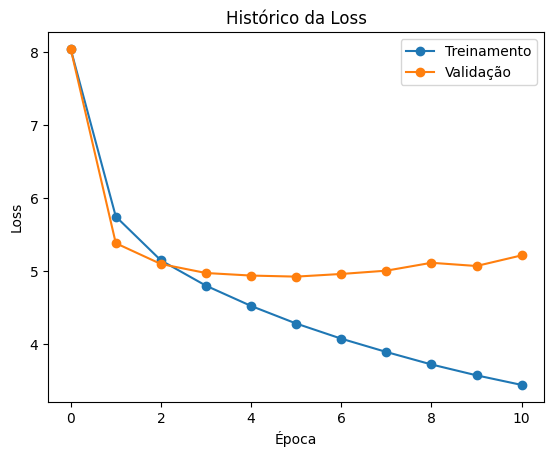

In [ ]:
plt.plot(hist["loss_train"], "o-")
plt.plot(hist["loss_val"], "o-")

plt.legend(["Treinamento", "Validação"])
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Histórico da Loss")

plt.show()

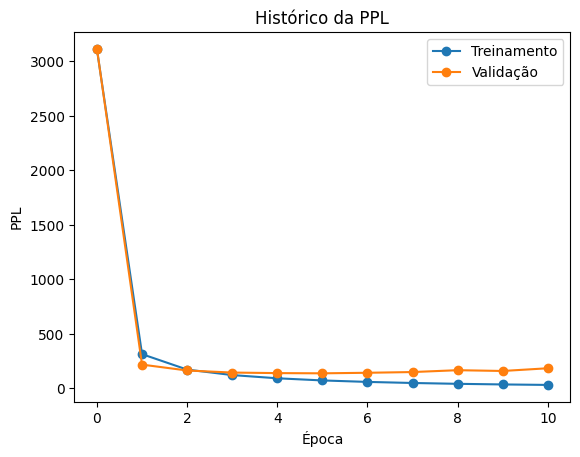

In [ ]:
plt.plot(hist["ppl_train"], "o-")
plt.plot(hist["ppl_val"], "o-")

plt.legend(["Treinamento", "Validação"])
plt.xlabel("Época")
plt.ylabel("PPL")
plt.title("Histórico da PPL")

plt.show()

Podemos perceber que, ao longo do treinamento, o modelo não sofreu muito com overfitting, dado que a Loss e a Perplexidade no conjunto de validação não começa a crescer conforme o tempo, apenas deixa de diminuir tanto quanto a Loss e a Perplexidade relativa ao conjunto de treinamento.

## Avaliação

In [ ]:
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Avalia modelo treinado nos dados de teste

loss, PPL = eval_model(model, test_loader, device)

print('Avaliação no conjunto de teste:')
print('---------------------------')
print(f'\tLoss:\t{loss:.4f}')
print(f'\tPPL:\t{PPL:.4f}')

Avaliação no conjunto de teste:
---------------------------
	Loss:	5.2380
	PPL:	188.2999


## Exemplo de uso

O texto passado para ser "continuado" pelo modelo não pode conter nenhum token fora do vocabulário, pois isso, caso o modelo implementado suportasse, ocasionaria em um comportamento indeterminado.

Neste caso, o modelo não suporta que sejam passados tokens desconhecidos nem textos com um contexto menor do que o *context_size* para serem completados até o *max_length*.

In [ ]:
def generate_text(model, text, max_length, use_multinomial=False, verbose=False):
    encoded_text = encode_sentence(text)

    assert len(encoded_text) >= context_size, f'Texto "{text}" possui tamanho menor do que o context_size = {context_size}. Tamanho do texto: {len(encoded_text)}.'
    assert -1 not in encoded_text, f'Contexto final do texto "{text}" possui um token não que não está no vocabulário! Contexto codificado: {" ".join(str(x) for x in encoded_text[-context_size:])}'

    while len(encoded_text) < max_length:
        context = encoded_text[-context_size:]

        input = torch.LongTensor(context)
        output = model(input).squeeze(dim=0)
        probs = F.softmax(output, dim=-1)

        if use_multinomial == True:
            next_token = torch.multinomial(probs, num_samples=1).item()
        else:
            next_token = probs.argmax().item()

        encoded_text.append(next_token)

        if verbose:
            print(f'Texto predito:\t{decode_sentence(encoded_text)}')

    return decode_sentence(encoded_text)

In [ ]:
max_length = 40
text = "A unica barreira que continha os Aymorés era a posição"

In [ ]:
print(f'O texto gerado utilizando o argmax foi:\n\t{generate_text(model, text, max_length=max_length, use_multinomial=False)}')

O texto gerado utilizando o argmax foi:
	a unica barreira que continha os aymorés era a posição , e que não ser o menor receio , aproximou - se , pery , a sua causa , a sua causa , a sua causa , a sua causa


In [ ]:
print(f'O texto gerado utilizando o multinomial foi:\n\t{generate_text(model, text, max_length=max_length, use_multinomial=True)}')

O texto gerado utilizando o multinomial foi:
	a unica barreira que continha os aymorés era a posição mata rapidamente a organisação pessoa mostrou certas para que ficava de inexprimivel perto mais como se pery passava morto a alguma hora , notas , tu és christão de quem


Podemos perceber que, se o modelo considera apenas o token com maior probabilidade, ele "entra em parafuso" e colapsa depois de alguns tokens gerados. Portanto, o modelo implementado não performa bem para gerar sentenças comprimidas nesse caso.

Isso pode ocorrer por conta do vocabulário e do tamanho do contexto relativamente pequenos. Porém, se aumentarmos muito o tamanho do vocabulário e do contexto, o modelo não tem bons resultado. Isso pode ser resultado de uma quantidade relativamente pequena de dados que foram utilizados para o treinamento.

Considerando, as probabilidades corretas que o modelo dá para cada token na hora de fazer uma escolha, é possível notar que os resultados são muito melhores.